*Stanislav Borysov [stabo@dtu.dk], DTU Management*
# Advanced Business Analytics

## Deep Learning - Part 2 - Recurrent Neural Networks (RNNs)

An RNN has a quite simple underlying idea that appeared to be very powerful in practice. It is capable of storing the state of the network so it has some notion of memory. The output of an RNN depends not only on the current input but also on the all previous inputs. RNNs are used to process variable-length sequences with particular emphasis on time-series predictions, speech synthesis, and natural language processing applications. However, it turned out that the plain RNN implementation was not practical due to the limited ability to maintain its memory for a long time. To address this issue, many recurrent neuron types were proposed. The most popular ones are the Long Short-Term Memory (LSTM) cell and Gated Recurrent Unit (GRU), which contain special gates to control and propagate their internal (or hidden) state in a more efficient way. Similar ideas were also applied to regular feed-forward NNs leading to various network architectures such as Deep Residual Networks and Highway Networks, which are capable of propagating information (both forward and backward) through hundreds of layers. These networks become highly efficient for image processing tasks.

<img src="rnn.png">

In this notebook, unlike the others in this course, you will not need to write your own code. However, you are highly encouraged to experiment with model architectures, features, hyperparameters, etc.

You can also take a look at the additional materials:
- A video about RNN/LSTM/GRU time series prediction: https://www.youtube.com/watch?v=2np77NOdnwk
- Another tutorial: https://www.kaggle.com/thebrownviking20/intro-to-recurrent-neural-networks-lstm-gru/notebook
- Andrej Karpathy, "The Unreasonable Effectiveness of Recurrent Neural Networks", http://karpathy.github.io/2015/05/21/rnn-effectiveness/
- Christopher Olah, "Understanding LSTM Networks", https://colah.github.io/posts/2015-08-Understanding-LSTMs/

### 1. RNNs for Time Series Prediction

*Partially based on [this](https://www.kaggle.com/thebrownviking20/intro-to-recurrent-neural-networks-lstm-gru/notebook) and [this](https://www.kaggle.com/charel/learn-by-example-rnn-lstm-gru-time-series/) Kaggle kernels*

In the first section, we will explore RNN examples for time series prediction.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
FIGSIZE = (15, 5)

#### 1.1 Prepare data

We will start with a synthetic data example to demonstrate the concepts. You can also check the performance of the models for the real data (stock prices) afterward.

In [2]:
def get_synthetic_data():
    """Generate non-linear synthetic data"""
    n_features = 3
    n_samples = 3000
    points = np.linspace(0, 1, n_samples)
    X = np.zeros((n_samples, n_features))
    # features
    X[:, 0] = 1.0 * np.sin(1.0 + 50.0 * points) + np.random.normal(0, 0.05, n_samples)
    X[:, 1] = 1.0 * np.sin(2.0 + 100.0 * points) + np.random.normal(0, 0.05, n_samples)
    X[:, 2] = 1.0 * np.sin(3.0 + 300.0 * points) + np.random.normal(0, 0.05, n_samples)
    # plot features
    plt.figure(figsize=FIGSIZE)
    plt.plot(points, X[:, 0])
    plt.plot(points, X[:, 1])
    plt.plot(points, X[:, 2])
    plt.show()
    # target variable
    y = X[:, 0] * X[:, 1] * X[:, 2]
    # plot target variable
    plt.figure(figsize=FIGSIZE)
    plt.plot(points, y)
    plt.show()
    # data format
    df = pd.DataFrame()
    df['y'] = y
    for i in range(n_features):
        df['x'+str(i)] = X[:, i]
    # target variable
    target_col = 'y'
    # features
    feature_cols = ['x'+str(i) for i in range(n_features)]
    # target variable is also included into the features
    # to make the model autoregressive
    feature_cols += ['y']
    return df, target_col, feature_cols

In [3]:
def get_stock_data():
    """Stock price data"""
    df = pd.read_csv('data/stock-time-series-20050101-to-20171231/all_stocks_2006-01-01_to_2018-01-01.csv', parse_dates=['Date'])
    df = pd.pivot_table(df, index='Date', values='Close', columns=['Name'], aggfunc='first')
    df = df.dropna()
    print(df.info())
    # target variable
    target_col = "IBM"
    # features
    feature_cols = [
        "IBM", # the target column is included to make the model autoregressive
        "AAPL", "AMZN", "GOOGL"
    ]
    return df, target_col, feature_cols

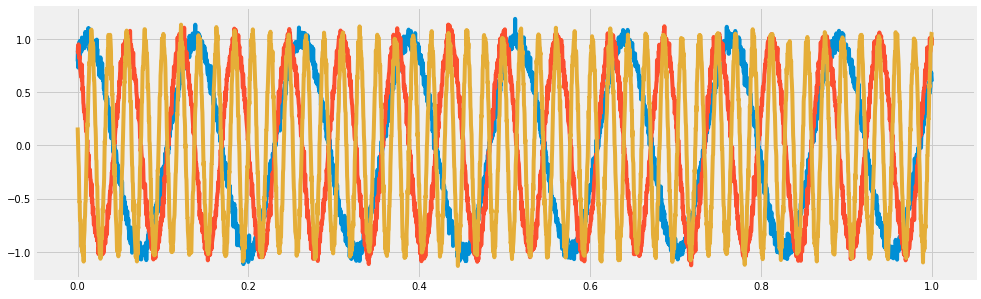

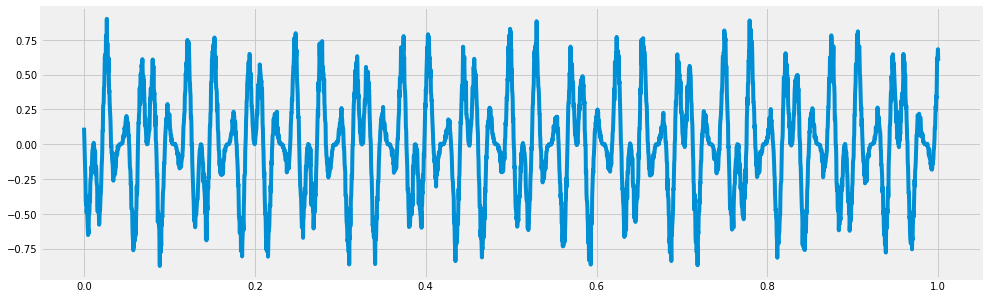

In [4]:
# get data for modeling
df, target_col, feature_cols = get_synthetic_data()
#df, target_col, feature_cols = get_stock_data()

Let's plot the target variable

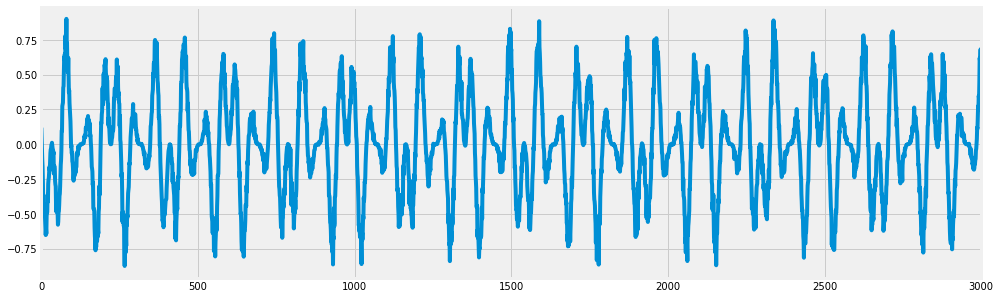

In [5]:
df[target_col].plot(figsize=FIGSIZE)
plt.show()

First, we need to define the prediction problem itself. The idea is to use a moving (rolling) windows of values as features of size `lag_window` and try to predict the next multiple values defined by `prediction_window`.

In [6]:
lag_window = 50
prediction_window = 50

Now, we need to get X and y from the data according to the problem definition. For the sake of time, we have a few helper functions defined throughout the notebook. We will use *docstrings* to document the code, which is a very good programming practice.

> Python Docstring is the documentation string which is string literal, and it occurs in the class, module, function or method definition, and it is written as a first statement. Docstrings are accessible from the doc attribute for any of the Python object and also with the built-in help() function can come in handy.
>
>Also, Docstrings are great for the understanding the functionality of the larger part of the code, i.e., the general purpose of any class, module or function whereas the comments are used for code, statement, and expressions which tend to be small. They are a descriptive text written by a programmer mainly for themselves to know what the line of code or expression does. It is an essential part that documenting your code is going to serve well enough for writing clean code and well-written programs. Though already mentioned there are no standard and rules for doing so.

You can read more about them [here](https://www.datacamp.com/community/tutorials/docstrings-python).

In [7]:
def prepare_data(df, target_col, feature_cols, lag_window, prediction_window):
    """A helper function for preparing datasets for modeling.
    It splits the data into a list of rolling windows,
    where the first seq_len values are to be used as features
    and the next value as a target variable.
    
     Args:
        df (pandas.DataFrame): Pandas DataFrame with data.
        target_col (str): Target column.
        lag_window (int): Rolling window size 
            (Number of historical values to use in modeling).
        
    Returns:
        tuple: (X, y, dates).
            
    """
    # split the data into rolling windows
    X, y, dates = [], [], []
    for index in range(len(df) - lag_window - 1 - prediction_window):
        # target values
        y.append(df[target_col][index + lag_window: 
                                index + lag_window + prediction_window])
        X_c = []
        # make sure that the lagged values are in the first feature
        if target_col in feature_cols:
            X_c.append(df[target_col][index: index + lag_window])
        for col_name in feature_cols:
            if col_name == target_col:
                continue
            X_c.append(df[col_name][index: index + lag_window])
        dates.append(df.index[index + lag_window])
        X.append(X_c)
    X, y, dates = np.array(X), np.array(y), np.array(dates)
    return X, y, dates

In [8]:
X, y, dates = prepare_data(df, target_col, feature_cols, lag_window, prediction_window)

In [9]:
# [n_samples, n_features, lag_window]
X_shape = X.shape
X_shape

(2899, 4, 50)

In [10]:
# [n_samples, prediction_window]
y_shape = y.shape
y_shape

(2899, 50)

For most models, except for RNNs, a 2D array of features is required.

In [11]:
# [n_samples, feature_1_lag_window + ... + feature_n_lag_window]
X = X.reshape((X_shape[0], X_shape[1] * X_shape[2]))
X.shape

(2899, 200)

Now we need to define a validation procedure. As the training of the DL models is computationally heavy without GPUs, we will use a simple test-train split, no cross-validation.

*Note: time series are correlated so we cannot shuffle the data points! You can read more about validation of time series models [here](https://scikit-learn.org/stable/modules/cross_validation.html#time-series-split) and [here](https://scikit-learn.org/stable/modules/cross_validation.html#a-note-on-shuffling)*

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
train_size=0.8 # first 80% of data will be used for train, the rest 20% for test
indices = np.arange(X_shape[0])
indices_train, indices_test = train_test_split(indices, 
                                               train_size=train_size, shuffle=False)
X_train, X_test, y_train, y_test = X[indices_train], X[indices_test], \
                                   y[indices_train], y[indices_test]
dates_train, dates_test = dates[indices_train], dates[indices_test]

Normalize data

In [14]:
from sklearn.preprocessing import StandardScaler

In [15]:
scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.transform(y_test)

Let us visualize the training and test data. Since we plan to do multi-step prediction, we plot only the first value of the target variable.

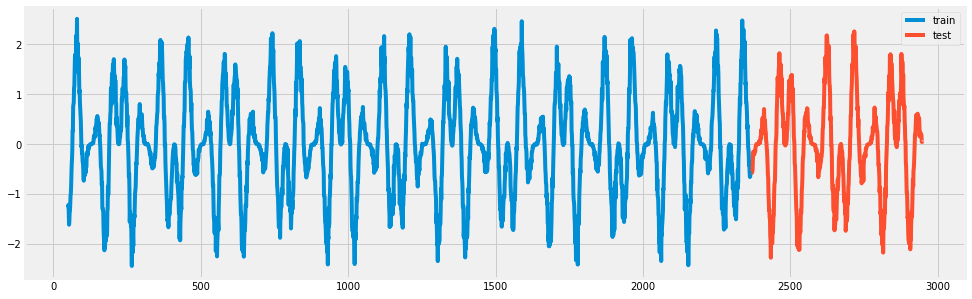

In [16]:
plt.figure(figsize=FIGSIZE)
plt.plot(dates_train, y_train[:, 0], label="train")
plt.plot(dates_test, y_test[:, 0], label="test")
plt.legend()
plt.show()

#### 1.2 Dummy model: Last value

As a baseline, we will use the model that predicts the most recent lagged value of the target variable. Here, we assume that the lagged target values are the first feature.

In [17]:
last_lag_ind = lag_window - 1

In [18]:
# last value of the first feature
y_pred = np.zeros(y_test.shape)
y_pred[:] = np.tile(X_test[:, last_lag_ind].reshape(-1, 1), prediction_window)

let's plot it and calculate the error

In [19]:
from sklearn.metrics import mean_squared_error

In [20]:
def analyze_results(y_true, y_pred, dates, horizon):
    """Plots the prediction for a given prediction horizon.
    If horizon>1 than it plots the prediction values after the current
    horizon, so the predictions do not overlap.
    RMSE is calculated for all the predicted values within the horizon."""
    print("Horizon:", horizon)
    y_true_plot = y_true[::horizon, :horizon].ravel()[:len(dates)]
    y_pred_plot = y_pred[::horizon, :horizon].ravel()[:len(dates)]
    plt.figure(figsize=FIGSIZE)
    plt.plot(dates[:len(y_true_plot)], y_true_plot, label='True Data') 
    plt.plot(dates[:len(y_true_plot)], y_pred_plot, label='Prediction') 
    plt.legend() 
    plt.show()
    #
    RMSE = np.sqrt(mean_squared_error(y_true[:, :horizon], y_pred[:, :horizon]))
    print("RMSE:", RMSE)

Horizon: 1


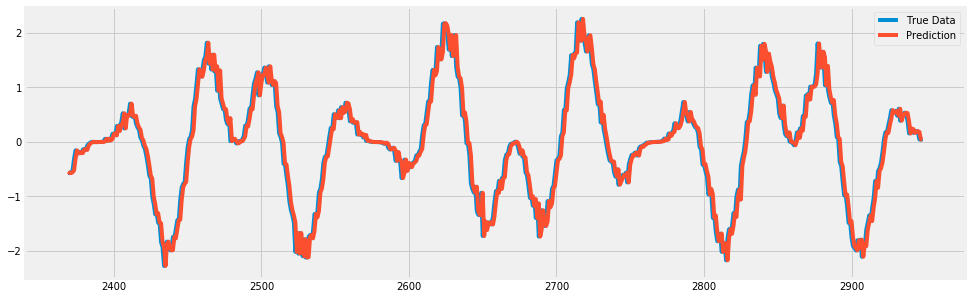

RMSE: 0.19521242824187088


In [21]:
analyze_results(y_test, y_pred, dates_test, 1)

We can see that the dummy model does a great job predicting the last known value of the target variable. However, the performance is not so great when multiple future values are predicted:

Horizon: 50


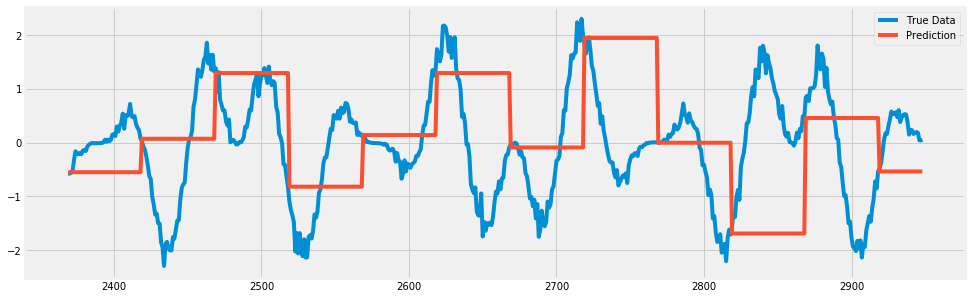

RMSE: 1.3809831832485786


In [22]:
analyze_results(y_test, y_pred, dates_test, prediction_window)

#### 1.3 Linear regression (sklearn)

Simple linear regression in sklearn

In [23]:
from sklearn.linear_model import LinearRegression

In [24]:
linear_model_sklearn = LinearRegression(fit_intercept=True)
linear_model_sklearn.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [25]:
y_pred = linear_model_sklearn.predict(X_test)

Horizon: 1


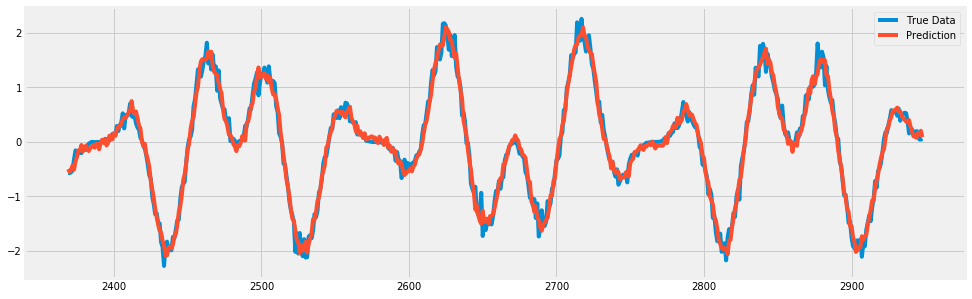

RMSE: 0.1469060754560165


In [26]:
analyze_results(y_test, y_pred, dates_test, 1)

Horizon: 50


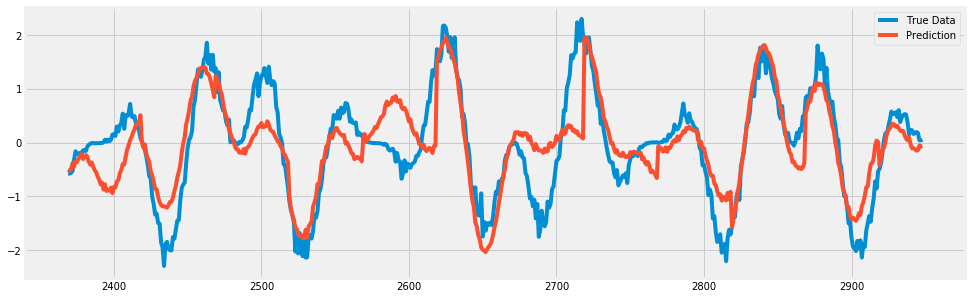

RMSE: 0.5732592776135907


In [27]:
analyze_results(y_test, y_pred, dates_test, prediction_window)

The performance of the linear model is better than the baseline. However, for the prediction of the multiple values ahead defined by `prediction_window` is still far from perfect.

#### 1.4 Linear regression (keras)

Now, let's implement the same linear regression model using NN in keras. In this case, a NN without activation functions (i.e., non-linearities) does the job. Note, since the model is fitted using gradient descent instead of the analytical solution using matrix inversion, a quite large number of training steps (epochs) might be required. Below, a small number of epochs is used (`epochs=50`) for the time's sake, so the fitted model can be slightly different from the sklearn implementation.

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import RMSprop, SGD, Adam

In [29]:
# https://gist.github.com/stared/dfb4dfaf6d9a8501cd1cc8b8cb806d2e
# live plotting of the learning curves
from IPython.display import clear_output
from tensorflow.keras.callbacks import Callback

class PlotLosses(Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.fig = plt.figure()
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        m1, m2 = 'loss', 'val_loss'
        #
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get(m1))
        self.val_losses.append(logs.get(m2))
        self.i += 1
        #
        clear_output(wait=True)
        #
        fig = plt.figure(figsize=(6, 4))
        plt.plot(self.x, self.losses, label='train')
        plt.plot(self.x, self.val_losses, label='validation', ls='--')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.yscale('log')
        plt.legend()
        plt.show()
        
plot_learning = PlotLosses()

In [30]:
def get_linear_model_keras(input_shape, output_size):
    """Build a linear model using NN"""
    model = Sequential()
    model.add(Dense(output_size, input_shape=input_shape, 
                    kernel_initializer='zeros', bias_initializer='zeros'))
    model.compile(loss='mean_squared_error', optimizer='RMSprop', metrics=['mse'])
    """
    # you can try to tune optimization parameters to speed up the training
    # for example
    optimizer = RMSprop(lr=0.01)
    # or
    optimizer = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
    # etc
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mse'])
    """
    #
    print(model.summary())
    return model

In [31]:
linear_model_keras = get_linear_model_keras(X_train.shape[1:], y_train.shape[1])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                10050     
Total params: 10,050
Trainable params: 10,050
Non-trainable params: 0
_________________________________________________________________
None


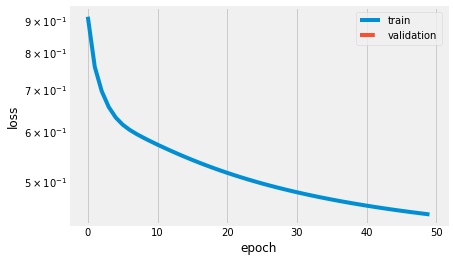

In [32]:
batch_size = 128
epochs = 50

history = linear_model_keras.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=0,
                    shuffle=False,
                    callbacks=[plot_learning], # plot learning progress
                    #validation_data=(X_test, y_test), 
                    # it's a sort of cheating to validate the error on the test set
                   )

In [33]:
y_pred = linear_model_keras.predict(X_test)

Horizon: 1


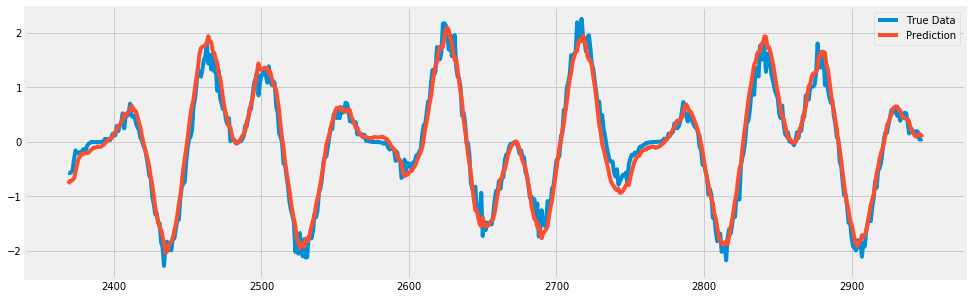

RMSE: 0.18938572120463432


In [34]:
analyze_results(y_test, y_pred, dates_test, 1)

Horizon: 50


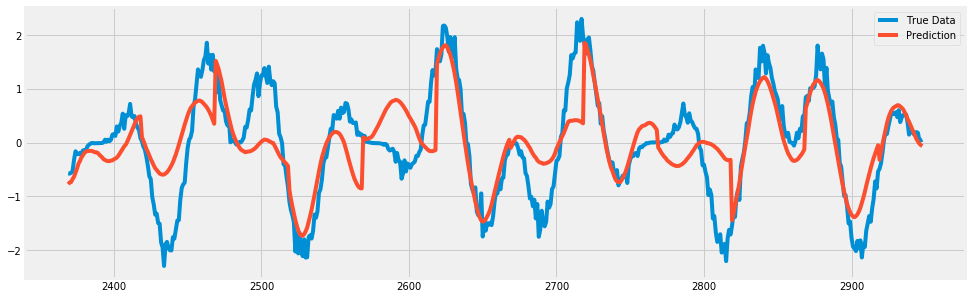

RMSE: 0.6624054745138935


In [35]:
analyze_results(y_test, y_pred, dates_test, prediction_window)

It shows kind of similar performance as sklearn implementation as expected.

#### 1.5 Fully connected NN regression (keras)

Let's finally try non-linear NN models in keras. Feel free to change the NN architecture or optimizer parameters, especially for the real data (stock prices).

In [36]:
def get_nonlinear_model_keras(input_shape, output_size):
    model = Sequential()
    model.add(Dense(100, input_shape=input_shape, activation='tanh'))
    # dropout example
    # https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/
    #model.add(Dropout(0.2))
    # another hidden layer ...
    #model.add(Dense(100, input_shape=input_shape, activation='tanh'))
    #model.add(Dropout(0.2))
    model.add(Dense(output_size))
    model.compile(loss='mse', optimizer='RMSprop', metrics=['mse'])
    #
    print(model.summary())
    return model

In [37]:
nonlinear_model_keras = get_nonlinear_model_keras(X_train.shape[1:], y_train.shape[1])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
Total params: 25,150
Trainable params: 25,150
Non-trainable params: 0
_________________________________________________________________
None


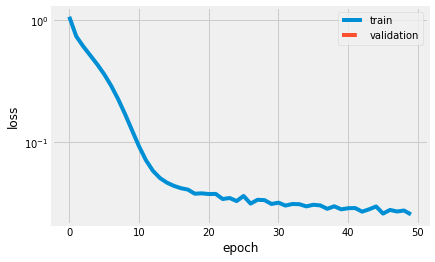

In [38]:
batch_size = 128
epochs = 50

history = nonlinear_model_keras.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=0,
                    shuffle=False,
                    callbacks=[plot_learning], # plot learning progress
                    #validation_data=(X_test, y_test), 
                    # it's a sort of cheating to validate the error on the test set
                   )

In [39]:
y_pred = nonlinear_model_keras.predict(X_test)

Horizon: 1


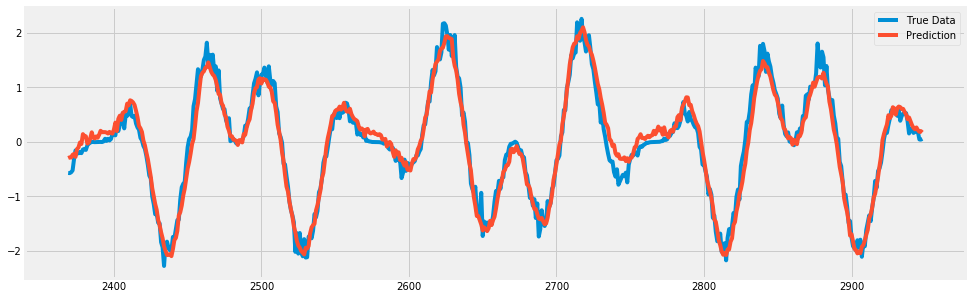

RMSE: 0.19538819521620532


In [40]:
analyze_results(y_test, y_pred, dates_test, 1)

Horizon: 50


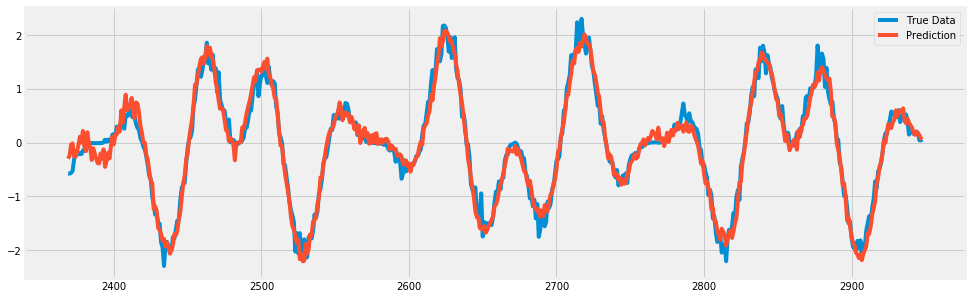

RMSE: 0.1821445873948521


In [41]:
analyze_results(y_test, y_pred, dates_test, prediction_window)

Much better than the linear model (for the synthetic data)!

#### 1.6 RNN regression (keras)

Let's implement a similar NN architecture with 1 hidden layer and 100 hidden units but now they are recurrent. Note that RNNs in keras take the data in the following format: `[n_samples, n_timestamps, n_features]`.

In [42]:
X_train_rnn = np.transpose(X_train.reshape((-1, X_shape[1], X_shape[2])), (0, 2, 1))
X_test_rnn = np.transpose(X_test.reshape((-1, X_shape[1], X_shape[2])), (0, 2, 1))
# [n_samples, n_timestamps, n_features]
X_train_rnn.shape

(2319, 50, 4)

In [43]:
from tensorflow.keras.layers import LSTM, SimpleRNN, GRU

In [44]:
def get_rnn_model_keras(input_shape, output_size, cell_type):
    """RNN model"""
    params = {}
    if cell_type=='SimpleRNN':
        cell_type_func = SimpleRNN
        params['activation'] = 'tanh'
    elif cell_type=='LSTM':
        cell_type_func = LSTM
        params['recurrent_activation'] = 'sigmoid'
    elif cell_type=='GRU':
        cell_type_func = GRU
    else:
        raise Exception("Unknown cell_type")
    #
    model = Sequential()
    # simple one-layer RNN
    model.add(cell_type_func(100, input_shape=input_shape, **params))
    # for a multi-layer stacked RNN, all but last layer 
    # should have "return_sequences=True"
    # https://keras.io/getting-started/sequential-model-guide/#stacked-lstm-for-sequence-classification
    # for example
    #model.add(cell_type_func(32, input_shape=input_shape, return_sequences=True, **params))
    #model.add(cell_type_func(32, return_sequences=True, **params))
    #model.add(cell_type_func(32, **params))
    model.add(Dense(output_size))
    model.compile(loss='mse', optimizer='RMSprop', metrics=['mse'])
    #
    print(model.summary())
    return model

In [45]:
rnn_model_keras = get_rnn_model_keras(X_train_rnn.shape[1:], y_train.shape[1], 'SimpleRNN')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 100)               10500     
_________________________________________________________________
dense_3 (Dense)              (None, 50)                5050      
Total params: 15,550
Trainable params: 15,550
Non-trainable params: 0
_________________________________________________________________
None


Note that the number of parameters is twice less than for the fully connected NN in the previous example!

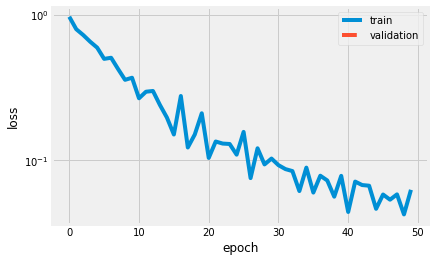

In [46]:
batch_size = 128
epochs = 50

history = rnn_model_keras.fit(X_train_rnn, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=0,
                    shuffle=False,
                    callbacks=[plot_learning], # plot learning progress
                    #validation_data=(X_test_rnn, y_test_rnn), 
                    # it's a sort of cheating to validate the error on the test set
                   )

In [47]:
y_pred = rnn_model_keras.predict(X_test_rnn)

Horizon: 1


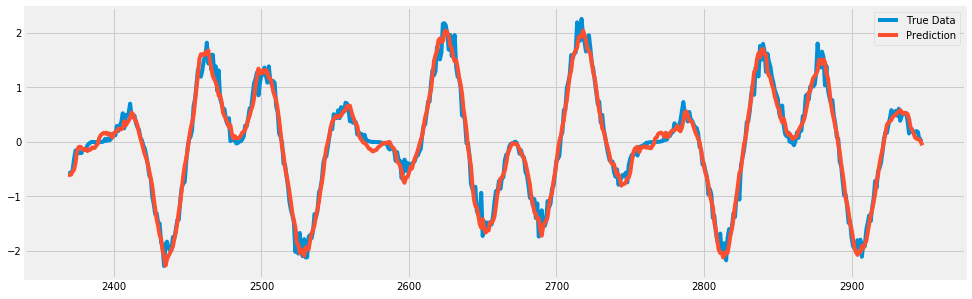

RMSE: 0.15490825245414586


In [48]:
analyze_results(y_test, y_pred, dates_test, 1)

Horizon: 50


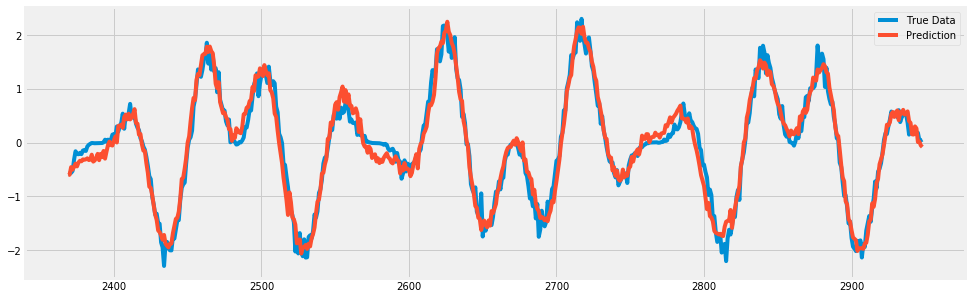

RMSE: 0.20377200698883968


In [49]:
analyze_results(y_test, y_pred, dates_test, prediction_window)

It shows similar performance as a fully connected NN but with fewer parameters.

***Practical note on RNNs***

**For the real-world applications, RNNs work the best for really complex non-linear problems with a lot of data samples available, such as sound or text. For simple time series prediction problems, Linear, ARIMA or shallow fully connected NN models usually work much better and you should always try them first before DL models.**

### 2. NLP with Recurrent Neural Networks

RNNs showed the best performance for the natural language processing (NLP) tasks. Go through the examples. You are not supposed to understand everything, just to give you a flavor of how resource-demanding deep learning is.

**WARNING IF YOU WANT TO RUN THE CODE! Both examples are too computationally demanding for a laptop. In the worst case, they can make your computer frozen. Save everything important if you want to run them.**

The cells with code below have the "Raw" type so the code is not executed. To run the code, change their format to "Code" either using the main menu or with the hotkeys (Select a cell by clicking on the white space left to the cell and press "y" for Code, "r" for Raw and "m" for Markdown). You can read more here: https://www.tutorialspoint.com/jupyter/jupyter_notebook_types_of_cells.htm

#### 2.1 IMDB sentiment classification

[ https://github.com/keras-team/keras/blob/master/examples/imdb_lstm.py ]

#### 2.2 Text generation example
[ https://github.com/keras-team/keras/blob/master/examples/lstm_text_generation.py ]

*It'll almost for sure destroy your computer :) You need a quite good GPU for this.*